# Olivetti Faces KMeans Trial

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from sklearn.base import BaseEstimator,TransformerMixin,clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from mltoolkit.utils import dump_model

## Loading Datasets

In [2]:
X_train = pd.read_csv("Datasets/X_train.csv",index_col=0)
y_train = pd.read_csv("Datasets/y_train.csv",index_col=0)
X_test = pd.read_csv("Datasets/X_test.csv",index_col=0)
y_test = pd.read_csv("Datasets/y_test.csv",index_col=0)

In [3]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((320, 4096), (320, 1), (80, 4096), (80, 1))

We are about to test whether PCA works well with KMeans's prediction accuracy.\
So we need to first find the best k of Kmeans model for both with and without PCA.

Since we have 40 classes in the original olivetti faces dataset, so we will start with k = 40 to k = 100 and see if the elbow exists.

In [134]:
def kmeans_find_k(X,k_list,annotation:str=None):
    '''
    Plot the inertia and silhouette scores against the n number of clusters.
    
    Parameters:
    ----------
    X: 2D-array
        Input dataset in 2 dimensional array or pandas.DataFrame.
    k_list: list or array
        The list of k number of clusters to try.
    annotation: str
        The text to show as a part of the title.
    
    Returns:
    ----------
    inertias: List of inertias.
    silhous: List of silhoutte scores.
    '''
    inertias = []
    silhous = []
    if annotation: title = f"Inertia and silhouette score ({annotation})"
    else: title = "Inertia and silhouette score"

    for k in k_list:
        k_model = KMeans(n_clusters=k).fit(X)
        inertias.append(k_model.inertia_)
        silhous.append(silhouette_score(X,k_model.labels_))

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.gca()
    ax2 = ax1.twinx()
    ax1.plot(k_list,inertias,c='b',label='inertia')
    ax2.plot(k_list,silhous,c='r',label='silhouette')
    ax1.set(title=title,xlabel="n clusters",ylabel="inertia")
    ax2.set(ylabel="silhouette score")
    fig.legend(loc=1)
    plt.show()
    
    return inertias,silhous

In [123]:
ks = range(40,201,20)

Trying the one without PCA transformation

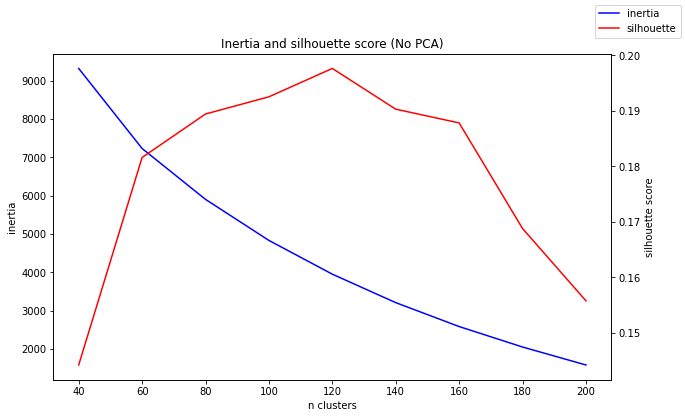

In [124]:
inertias_nopca,silhous_nopca = kmeans_find_k(X_train,ks,"No PCA")

In [125]:
kbest_nopca = ks[np.argmax(np.array(silhous_nopca))]
kbest_nopca

120

Trying the one with PCA transformation

In [4]:
pca = PCA(n_components=260)
X_train_pca = pca.fit_transform(X_train)

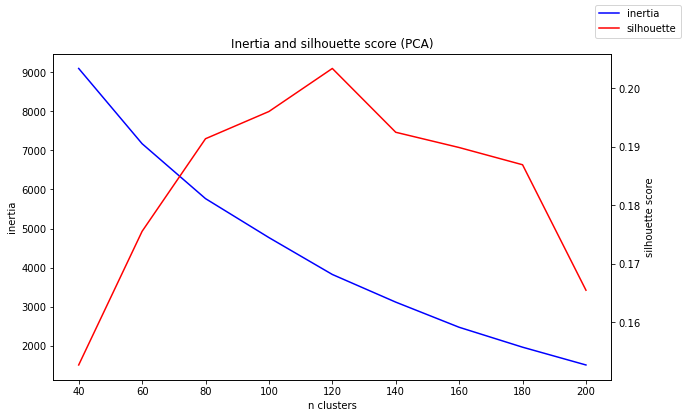

In [126]:
inertias_pca,silhous_pca = kmeans_find_k(X_train_pca,ks,"PCA")

In [127]:
kbest_pca = ks[np.argmax(np.array(silhous_pca))]
kbest_pca

120

In [131]:
np.array(inertias_pca) < np.array(inertias_nopca)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [129]:
np.array(silhous_pca) > np.array(silhous_nopca)

array([ True, False,  True,  True,  True,  True,  True,  True,  True])

We can see that the inertia for the models with PCA transformation is all lesser than the one without.\
The silhouette scores for the models with PCA transformation also mostly greater than the one without.\
We now understand that PCA does help a little bit in forming better clusters and it also reduces a lot of memory usage.

Now we know that KMeans model works best with k = around 120 and with a PCA transformation on the input data with 260 components.

We will train one KMeans model with the best condition and gain some insights about its clusters and clustering accuracy.

In [3]:
pca = PCA(n_components=260)
X_train_pca = pca.fit_transform(X_train)

In [138]:
np.savetxt("Datasets\\X_train_pca.csv",X_train_pca,delimiter=',',encoding='utf-8')

In [4]:
knn_0 = KMeans(n_clusters=120).fit(X_train_pca)

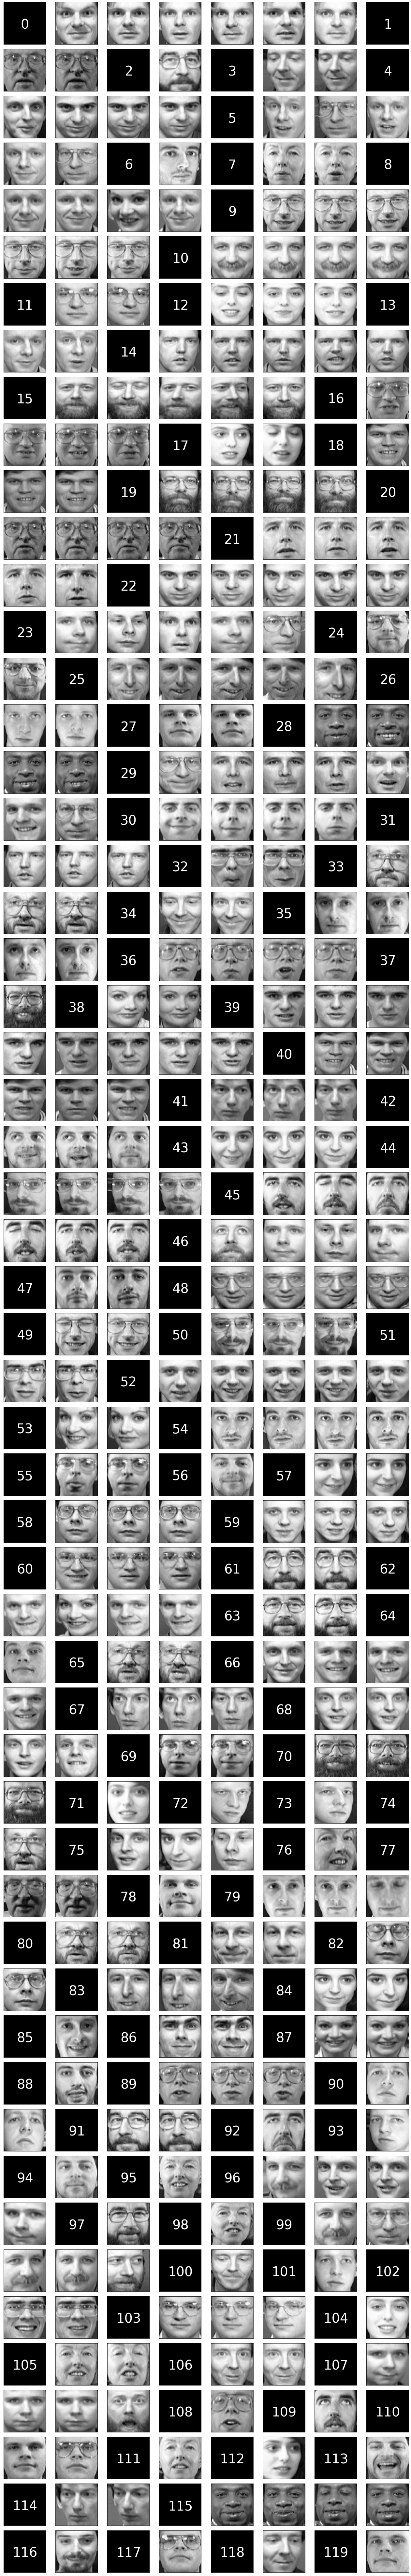

In [93]:
axes_num = np.unique(knn_0.labels_).size + knn_0.labels_.size
row_num = ceil(axes_num/8)
cur_ax = 0
fig,axs = plt.subplots(row_num,8,figsize=(18,2*row_num),tight_layout=True,facecolor='w')
axs = axs.flat
ax_black = np.ones((64,64))*1

for label in np.unique(knn_0.labels_):
    mask = (knn_0.labels_ == label)
    images_of_label = X_train[mask].values
    
    axs[cur_ax].imshow(ax_black,cmap='gray')
    axs[cur_ax].text(32,32,label,c='w',size=40,ha='center',va='center_baseline')
    axs[cur_ax].set(xticks=[],yticks=[])
    cur_ax += 1
    
    for image in images_of_label:
        axs[cur_ax].imshow(image.reshape((64,64)),cmap='gray')
        axs[cur_ax].set(xticks=[],yticks=[])
        cur_ax += 1

plt.show()

Most of the clusters have majority of the same faces. The KMeans model performed better than expectation.

Now we will look at the prediction accuracy.

In [9]:
def kmeans_translate_label(model,y_true,y_pred=None):
    if y_true is not np.ndarray:
        np.array(y_true)
    if y_pred is None:
        output = np.full_like(knn_0.labels_,-1)
        labels = np.unique(model.labels_)
        target_labels = model.labels_
    else:
        output = np.full_like(y_pred,-1)
        labels = np.unique(y_pred)
        target_labels = y_pred
    
    for label in labels:
        mask = (target_labels == label)
        output[mask] = mode(y_true[mask])[0]
    return output

In [133]:
knn_0_yhat = kmeans_translate_label(knn_0,y_train.loc[:,'0'].values)
knn_0_yhat

array([ 7, 19,  2, 13, 20,  4,  8, 22,  7, 21, 31, 19, 21, 22, 21,  2, 28,
        7,  0, 37, 25, 14, 18, 25, 13, 19,  6, 35, 14,  5, 24, 28, 23, 24,
        7, 23, 29,  6, 17,  5, 20, 31, 15, 21,  1, 15,  0,  9, 30,  0, 19,
       21, 15, 17, 16,  1, 36, 32, 10, 20, 36, 34, 39, 38, 26, 38, 29,  9,
        4, 26, 32, 29, 18, 28, 20, 28, 33,  0, 33, 10, 30,  8, 31,  4,  8,
       10, 18, 38, 16, 33, 35, 22, 13, 37,  2, 27, 37, 22, 37,  9, 22, 27,
       38, 32, 21, 32, 24,  0, 35, 24,  4,  6, 11,  8, 35,  4, 24, 15, 15,
       39,  3, 22, 17, 27, 33, 11,  4, 33, 23, 10, 20, 37,  7, 36,  1, 39,
       25, 39, 29,  5,  8, 14,  1,  1, 29, 20,  1, 29, 33, 26,  7, 39, 14,
       13, 16, 27, 15, 20,  3, 11, 10,  5, 18, 18,  3, 34, 34, 22, 13,  3,
       33, 16,  4, 32, 22,  7,  0, 11, 11, 16, 27, 21, 19, 32, 17, 33, 14,
       14, 31, 24, 19, 30, 25, 14, 32,  7, 35, 12, 39, 28, 27, 11, 15, 31,
       14, 26,  6,  8,  9, 19, 23,  5, 16, 38, 30, 26, 36, 38, 24, 22, 31,
       16,  0,  1, 18, 39

In [135]:
knn_0_acc = np.mean(knn_0_yhat == y_train.loc[:,'0'].values)
knn_0_acc

0.928125

Our model has nearly 93% clustering accuracy on the training dataset.

In [5]:
X_test_pca = pca.transform(X_test)
knn_0_yhat_test = knn_0.predict(X_test_pca)

In [10]:
knn_0_yhat_test = kmeans_translate_label(knn_0,y_test.loc[:,'0'].values,knn_0_yhat_test)
knn_0_yhat_test

array([37, 12, 34, 22,  2, 21, 18, 28, 31, 15, 10, 30, 19, 23, 32,  3, 11,
        3, 34,  2, 36, 31,  5, 32,  9, 25,  0, 23, 30, 16, 29, 16, 35, 13,
       37, 26, 35, 17, 29,  7, 18, 33,  2, 15, 20, 22, 11, 11, 10, 27,  0,
        4, 21, 36, 27,  9, 28,  1, 24, 20,  1,  6,  8, 26,  0,  6,  0, 39,
       12, 38, 24, 13, 19,  8, 33, 12, 12,  5,  3, 38])

In [11]:
knn_0_test_acc = np.mean(knn_0_yhat_test == y_test.loc[:,'0'].values)
knn_0_test_acc

0.8875

We have around 89% on the test dataset.

### Saving the model

In [137]:
dump_model(knn_0,"Trained Models\\knn_0\\","knn_0",knn_0_yhat,knn_0_acc)

### Loading the model

In [3]:
knn_0 = joblib.load("Trained Models\\knn_0\\knn_0.pkl")